In [1]:
import torch, time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc

In [2]:
torch.cuda.empty_cache()

# Define a 1D CNN-LSTM Model for PCA-reduced data
class CNN_LSTM_1D(nn.Module):
    def __init__(self, seq_length=20, num_classes=2):
        super(CNN_LSTM_1D, self).__init__()
        # Input expected: (batch_size, seq_length, feature_dim) where feature_dim=1.
        # For Conv1d, input should be (batch_size, channels, seq_length); here channels=1.
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1)  # output: (batch_size, 32, seq_length)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=2)  # halves the seq_length

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)  # output: (batch_size, 64, seq_length/2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=2)  # output: (batch_size, 64, seq_length/4)

        # With seq_length=20, after two poolings: 20 -> 10 -> 5.
        # Interpret as a sequence of length 5 with 64 features each.
        self.lstm = nn.LSTM(input_size=64, hidden_size=128, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_length, 1)
        # For Conv1d, we want (batch_size, channels=1, seq_length)
        x = x.transpose(1, 2)  # now shape: (batch_size, 1, seq_length)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        # Now shape: (batch_size, 64, seq_length/4) -> (batch_size, 64, 5)
        x = x.transpose(1, 2)  # now shape: (batch_size, 5, 64)
        x, _ = self.lstm(x)   # LSTM outputs (batch_size, 5, 128)
        x = self.dropout(x[:, -1, :])  # take last time step output
        x = self.fc(x)
        return x

In [3]:
# Load SWaT dataset
data = pd.read_csv('data/swat_data.csv')
data = data.iloc[-int(0.5 * len(data)):]  # Use last 50% of data

# Process timestamps
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='mixed')
data.set_index('Timestamp', inplace=True)
data.sort_index(inplace=True)

# Identify non-numeric columns and drop them, except for 'Normal/Attack'
non_numeric_cols = data.select_dtypes(include=['object']).columns
if 'Normal/Attack' in non_numeric_cols:
    non_numeric_cols = non_numeric_cols.drop('Normal/Attack')
data = data.drop(columns=non_numeric_cols)

# Encode labels for binary classification (Normal = 0, Attack = 1)
# labels = (data['Normal/Attack'] != 'Normal').astype(int)
labels = data['Normal/Attack']
data = data.drop(columns=['Normal/Attack'])

# Scale features and apply PCA
print(f"Number of features before PCA: {data.shape[1]}")
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

pca_components = 20
pca = PCA(n_components=pca_components)
data_pca = pca.fit_transform(data_scaled)
print(f"Explained variance ratio (PCA): {pca.explained_variance_ratio_.sum():.4f}")

# Reshape PCA output: each sample becomes a sequence of length 20 with 1 feature per time step.
data_normalized = data_pca.reshape(-1, pca_components, 1)

Number of features before PCA: 51
Explained variance ratio (PCA): 0.9778


In [4]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data_normalized, labels, test_size=0.2, random_state=42)

# DataLoader Class without unsqueeze (each sample is already (20,1))
batch_size = 128
def create_dataloader(X, y, batch_size=batch_size, shuffle=True):
    dataset = [(torch.tensor(X[i], dtype=torch.float32), 
                torch.tensor(y.iloc[i], dtype=torch.long)) for i in range(len(y))]
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = create_dataloader(X_train, y_train, batch_size=batch_size, shuffle=True)
test_loader = create_dataloader(X_test, y_test, batch_size=batch_size, shuffle=False)

In [5]:
# Compute class weights
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_train)
class_weights_np = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
print("Computed class weights:", class_weights_np)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transfer Learning: Initialize model and load pretrained weights
# Note: Use the appropriate architecture parameters. Here we use seq_length equal to 20.
model = CNN_LSTM_1D(seq_length=pca_components, num_classes=2).to(device)
pretrained_path = "models/08_cnn_lstm_pca_swat.pth"  # Update this path to your pretrained checkpoint
model.load_state_dict(torch.load(pretrained_path))
print("Pretrained weights loaded.")

# Freeze CNN layers to use as fixed feature extractor
for param in model.conv1.parameters():
    param.requires_grad = False
for param in model.conv2.parameters():
    param.requires_grad = False

# Set up optimizer to fine-tune only parameters that require gradients (LSTM and FC)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, weight_decay=1e-4)

# Use class weights in loss function
class_weights = torch.tensor(class_weights_np, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

Computed class weights: [0.5652146  4.33349736]
Pretrained weights loaded.


In [6]:
# Training Loop
num_epochs = 10
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

total_time = time.time() - start_time
print(f"Training time: {total_time:.4f} s")

Epoch [1/10], Loss: 0.0214
Epoch [2/10], Loss: 0.0196
Epoch [3/10], Loss: 0.0194
Epoch [4/10], Loss: 0.0189
Epoch [5/10], Loss: 0.0182
Epoch [6/10], Loss: 0.0178
Epoch [7/10], Loss: 0.0180
Epoch [8/10], Loss: 0.0176
Epoch [9/10], Loss: 0.0177
Epoch [10/10], Loss: 0.0172
Training time: 95.3009 s


In [7]:
# Evaluation
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
auc_score = roc_auc_score(y_true, y_pred)

print(f"\nAccuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF1-score: {f1:.4f}\nAUC: {auc_score:.4f}\n")
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
print("\nConfusion Matrix:")
print(cm_df)


Accuracy: 0.9930
Precision: 0.9495
Recall: 0.9919
F1-score: 0.9702
AUC: 0.9925


Confusion Matrix:
          Predicted 0  Predicted 1
Actual 0        83167          577
Actual 1           88        10840


In [8]:
# Save model
save_path = "models/08_cnn_lstm_pca_finetuned_swat.pth"
torch.save(model.state_dict(), save_path)

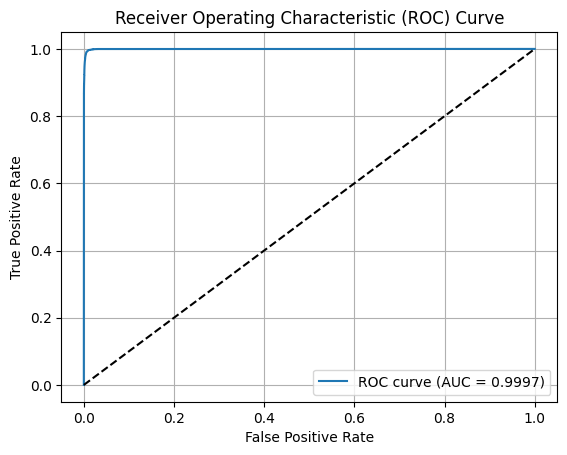

In [9]:
import matplotlib.pyplot as plt
# Get probabilities (for binary classification, we use prob for class 1)
y_scores = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Get prob for class 1
        y_scores.extend(probs.cpu().numpy())

# Now compute ROC data
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()